In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

In [3]:
import joblib
lda = joblib.load('/kaggle/input/models-cifake-all-features/LinearDiscriminantAnalysis.pkl')

In [4]:
lda.feature_names_in_

array(['R_original_firstorder_10Percentile',
       'R_original_firstorder_90Percentile',
       'R_original_firstorder_Energy', ...,
       'sym3_B_wavelet-L_ngtdm_Complexity',
       'sym3_B_wavelet-L_ngtdm_Contrast',
       'sym3_B_wavelet-L_ngtdm_Strength'], dtype=object)

## Load the data

In [5]:
def skip_half_rows(x):
    # x is the row id 
    # is function evaluates to 
    # True the row is skipped
    # NOTE: index numbering starts with the first line of file, so column row has the id = 0
    return not (x % 2 == 0) # keep even indexes

data_path = "/kaggle/input/cifake-all-features/RGB_train_all_features.csv"
df = pd.read_csv(data_path, index_col=0, skiprows=skip_half_rows)

columns_initial = df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1 to 99999
Columns: 9075 entries, Image to sym3_B_wavelet-L_ngtdm_Strength
dtypes: float64(9015), int64(7), object(53)
memory usage: 3.4+ GB


In [6]:
df.head()

,Image,Mask,Category,R_diagnostics_Versions_PyRadiomics,R_diagnostics_Versions_Numpy,R_diagnostics_Versions_SimpleITK,R_diagnostics_Versions_PyWavelet,R_diagnostics_Versions_Python,R_diagnostics_Configuration_Settings,R_diagnostics_Configuration_EnabledImageTypes,...,sym3_B_wavelet-L_gldm_LargeDependenceLowGrayLevelEmphasis,sym3_B_wavelet-L_gldm_LowGrayLevelEmphasis,sym3_B_wavelet-L_gldm_SmallDependenceEmphasis,sym3_B_wavelet-L_gldm_SmallDependenceHighGrayLevelEmphasis,sym3_B_wavelet-L_gldm_SmallDependenceLowGrayLevelEmphasis,sym3_B_wavelet-L_ngtdm_Busyness,sym3_B_wavelet-L_ngtdm_Coarseness,sym3_B_wavelet-L_ngtdm_Complexity,sym3_B_wavelet-L_ngtdm_Contrast,sym3_B_wavelet-L_ngtdm_Strength
1,D:\studia_zadania\Others\AIImageDetection\data...,D:\studia_zadania\Others\AIImageDetection\data...,0,v3.0.1,1.25.2,2.3.1,1.5.0,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",...,0.121249,0.038958,0.627387,88.291938,0.024955,0.244221,0.020355,143.809539,0.135964,2.892842
3,D:\studia_zadania\Others\AIImageDetection\data...,D:\studia_zadania\Others\AIImageDetection\data...,0,v3.0.1,1.25.2,2.3.1,1.5.0,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",...,0.036432,0.015490,0.690321,146.112196,0.011059,0.117546,0.019500,404.573111,0.066753,6.742380
5,D:\studia_zadania\Others\AIImageDetection\data...,D:\studia_zadania\Others\AIImageDetection\data...,0,v3.0.1,1.25.2,2.3.1,1.5.0,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",...,0.116522,0.039532,0.740831,93.557671,0.024763,0.339781,0.020632,242.850164,0.080504,6.273661
7,D:\studia_zadania\Others\AIImageDetection\data...,D:\studia_zadania\Others\AIImageDetection\data...,0,v3.0.1,1.25.2,2.3.1,1.5.0,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",...,0.060377,0.022634,0.691569,115.006402,0.015114,0.155328,0.034512,140.792999,0.054886,8.338564
9,D:\studia_zadania\Others\AIImageDetection\data...,D:\studia_zadania\Others\AIImageDetection\data...,0,v3.0.1,1.25.2,2.3.1,1.5.0,3.10.11,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'Wavelet': {}, 'Square': {}, ...",...,0.014221,0.007376,0.672309,199.806532,0.005969,0.092343,0.021758,210.355579,0.083002,6.233881


## Data preparation

In [7]:
from sklearn.model_selection import train_test_split

# leave in df only the features that are in the lda model
X = df[lda.feature_names_in_]
y = df[['Category']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [8]:
del X_train
del y_train
del df

import gc
gc.collect()

0

### Scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

# scaler = joblib.load('/kaggle/input/models-cifake-all-features/scaler.pkl')
# X_val_scaled = scaler.transform(X_val.values)
X_val_scaled = X_val.values

# create df from scaled data
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
    
    return accuracy, f1, precision, recall

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [11]:
evaluate_model(lda, X_val_scaled, y_val)

Model: None
Accuracy: 0.4942
F1: 0.3269
Precision: 0.2442
Recall: 0.4942


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4942, 0.32690890108419224, 0.24423363999999997, 0.4942)

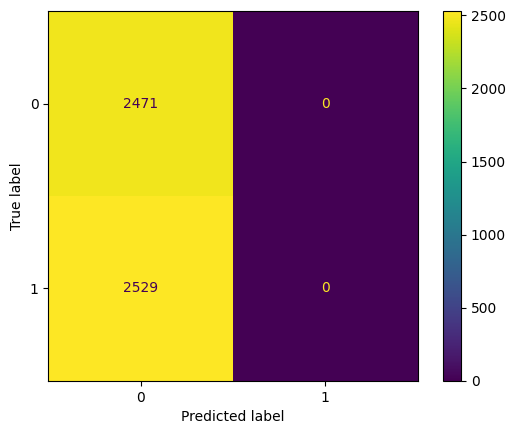

In [12]:
plot_confusion_matrix(lda, X_val_scaled, y_val)

## Feature importance

In [13]:
from sklearn.inspection import permutation_importance

def plot_top_importances(clf, X, y, top=10, clf_name=None, random_state=SEED):
    if clf_name is None:
        clf_name = clf.__class__.__name__
    try:
        result = permutation_importance(
            clf, X, y, n_repeats=10, random_state=random_state, n_jobs=-1
        )

        sorted_importances_idx = result.importances_mean.argsort()
        importances = pd.DataFrame(
            result.importances[sorted_importances_idx].T,
            columns=X.columns[sorted_importances_idx],
        ) 
        sorted_importances_idx_top10 = result.importances_mean.argsort()[-10:]
        importances_top10 = pd.DataFrame(
            result.importances[sorted_importances_idx].T,
            columns=X.columns[sorted_importances_idx],
        )
        ax = importances_top10.plot.box(vert=False, whis=10)
        ax.set_title(f"Permutation Importances {clf_name}")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()
        plt.show()
        return importances
    except Exception as e:
        print(f"During processing {clf_name}. Exception: {e} occurred.")

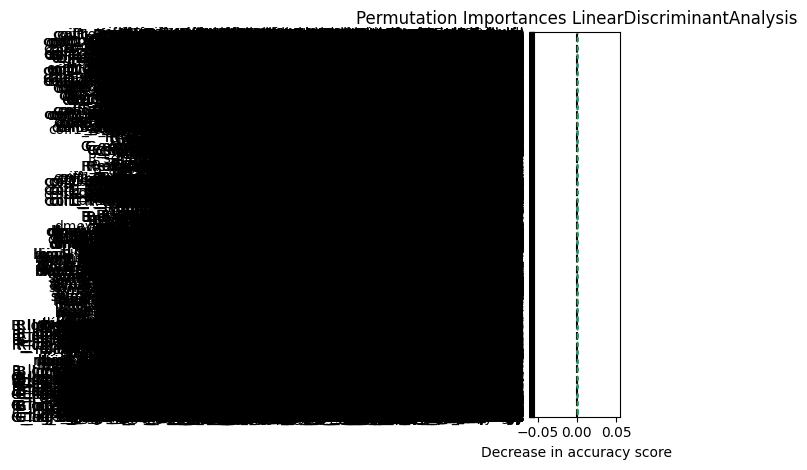

In [14]:
importances = plot_top_importances(lda, X_val, y_val)
importances.to_csv(f"importances_LinearDiscriminantAnalysis.csv")